This .ipynb file was running on JupyterLab.

Import Library

In [1]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from PIL import Image
from collections import defaultdict

import random

import cv2
from skimage import exposure

# 1. Objectives

Conduct exploratory data analysis on the eye diseases classification dataset, including cataract, diabetic retinopathy, glaucoma, and normal conditions, to uncover key patterns and insights. These findings will support the development of machine learning models and provide valuable insights for stakeholders.

# 2. Data Understanding

Here's how each eye disease looks different in a **fundus photograph** (a picture of the inside of the eye):
1. **Cataract**: In a fundus photo, cataracts aren’t directly visible because they affect the lens, which is in the front of the eye. However, if the cataract is very severe, the lens might look white or cloudy when taking a photo of the retina.
2. **Diabetic Retinopathy**: This condition shows up as small red spots (called microaneurysms) or bigger areas of bleeding in the retina. We might also see yellowish spots (exudates) or swelling in the retina. Over time, new blood vessels can form, which might look like tiny, abnormal veins growing in the retina.
3. **Glaucoma**: In a fundus photo, glaucoma is often seen as damage to the optic nerve. This may appear as a larger "cup" or hollow space in the center of the optic nerve. It might also show thinning of the retinal nerve fiber layer, which can look like a pale or less distinct optic disc.
4. **Normal**: In a normal fundus photograph, the retina will look healthy with a clear optic nerve, smooth blood vessels, and no signs of bleeding, swelling, or unusual growths. The optic disc (the area where the optic nerve enters) will have a normal appearance with a visible central "cup" that’s not too large.

In [2]:
# Path to the dataset
dataset_dir = 'dataset'

In [3]:
# Function to check if a file is an image based on extension
def is_image(file_name):
    valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff', '.webp']
    return any(file_name.lower().endswith(ext) for ext in valid_extensions)

In [4]:
# List the classes (directories in dataset)
class_names = os.listdir(dataset_dir)
print("Class Names:", class_names)

Class Names: ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']


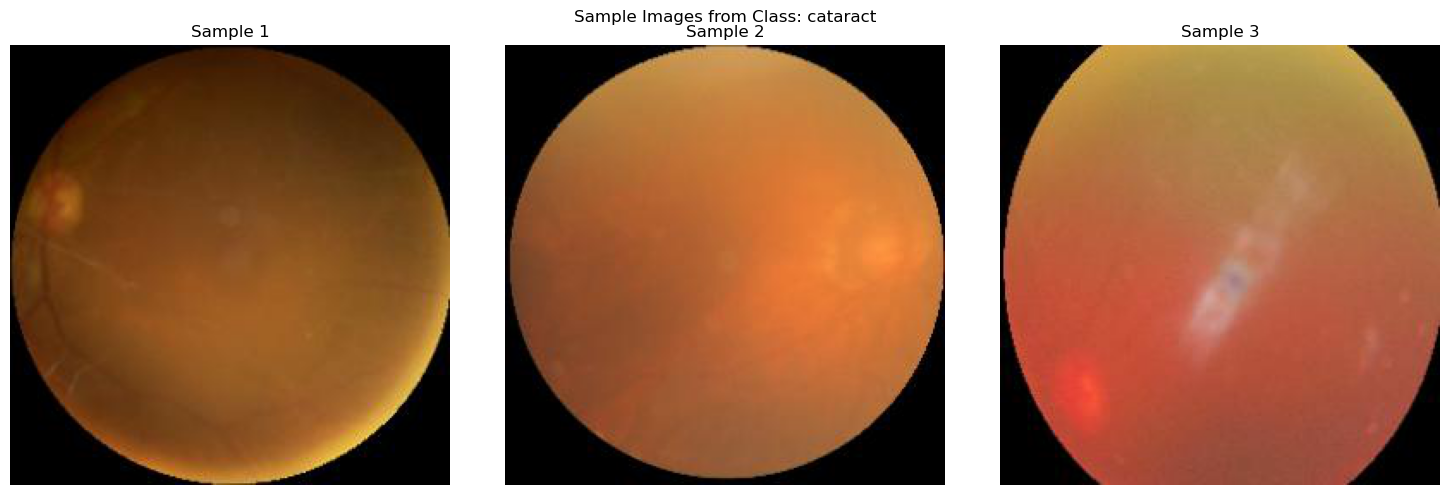

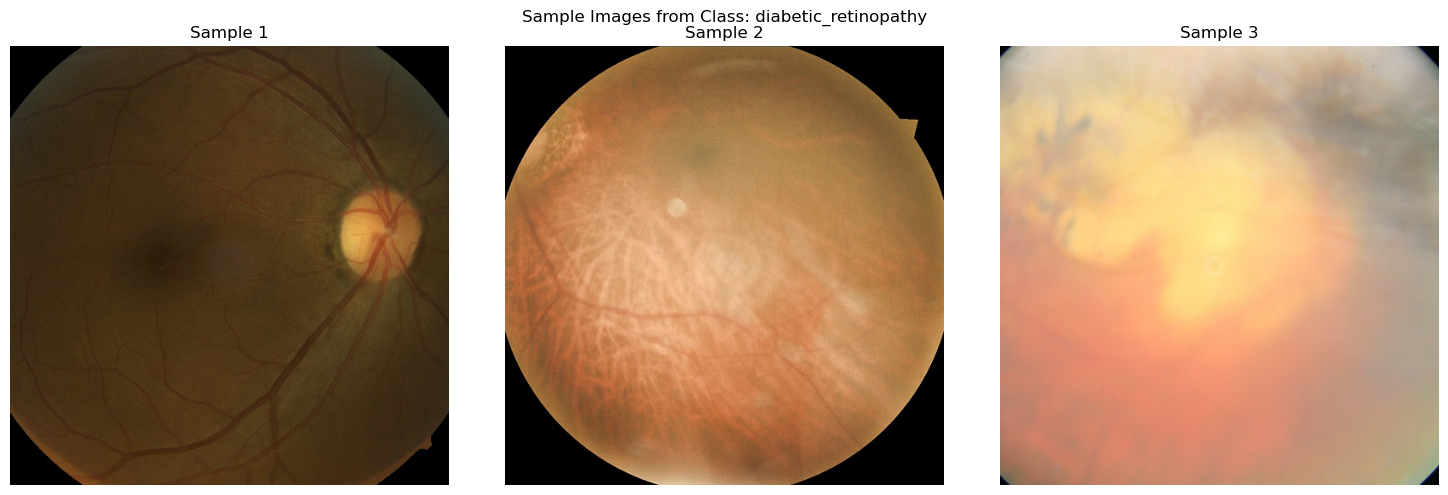

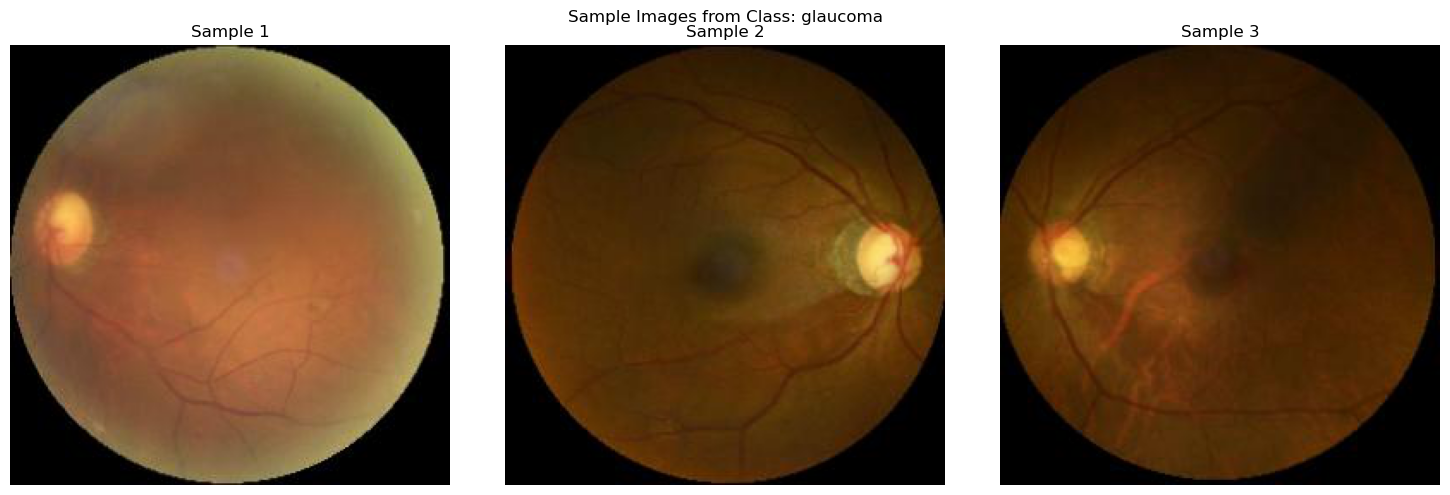

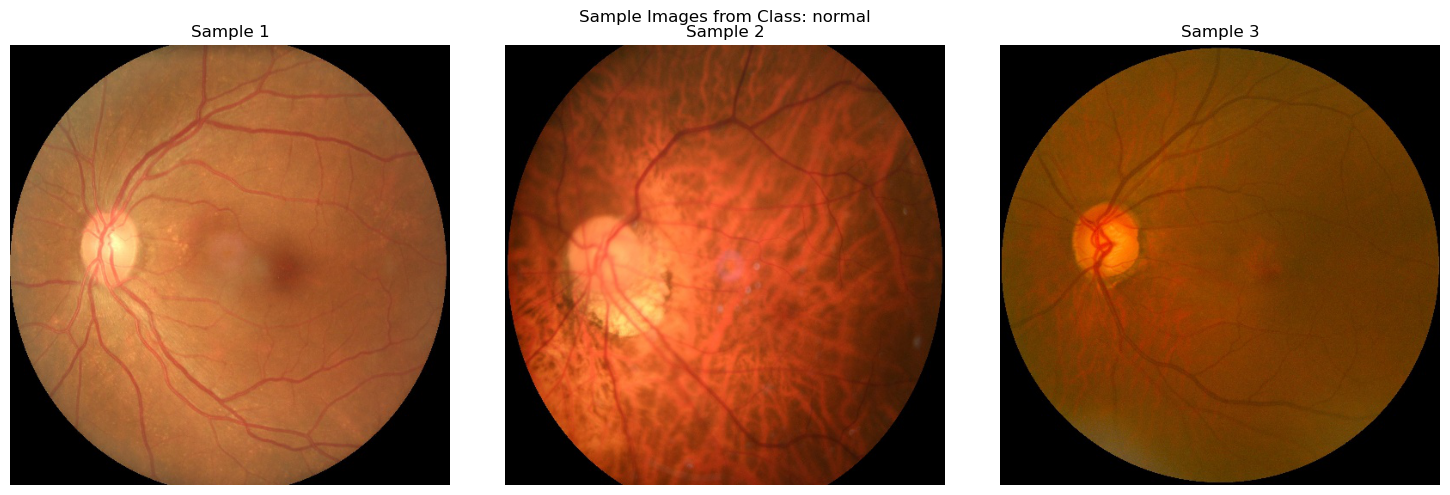

In [5]:
# Display 3 random sample images for each class
for class_name in class_names:
    class_path = os.path.join(dataset_dir, class_name)
    if os.path.isdir(class_path):
        # Get a list of image files in the class folder
        image_files = [f for f in os.listdir(class_path) if is_image(f)]
        
        # Check if there are enough images to sample
        if len(image_files) >= 3:
            # Randomly sample 3 image files from the class folder
            sampled_images = random.sample(image_files, 3)
            
            # Display 3 random sample images
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            fig.suptitle(f"Sample Images from Class: {class_name}")
            
            for i, image_file in enumerate(sampled_images):
                img = Image.open(os.path.join(class_path, image_file))
                axes[i].imshow(img)
                axes[i].axis('off')  # Hide axis
                axes[i].set_title(f"Sample {i+1}")
            
            plt.tight_layout()
            plt.show()

# 3. Data preprocessing

## 3.1 Check Dataset Structure

In [6]:
# Initialize dictionaries to store image format counts and class distribution
image_format_counts = defaultdict(int)
class_image_counts = defaultdict(int)  # To count images per class
total_images = 0  # Total count of images

In [7]:
# Initialize a list to store image sizes
image_sizes = []

In [8]:
# Loop through the dataset and count image formats, class distributions, and sizes
for class_name in class_names:
    class_path = os.path.join(dataset_dir, class_name)
    
    # Check if it's a directory (class folder)
    if os.path.isdir(class_path):
        # Initialize class image counter
        class_count = 0
        # Loop through each file in the class directory
        for file_name in os.listdir(class_path):
            if is_image(file_name):
                # Count the image format (extension)
                file_extension = os.path.splitext(file_name)[-1].lower()
                image_format_counts[file_extension] += 1
                # Increment the class image count
                class_count += 1
                total_images += 1
                
                # Load the image to get its size
                img = Image.open(os.path.join(class_path, file_name))
                image_sizes.append((class_name, img.size))  # Store (class_name, (width, height))
        
        # Update class distribution
        class_image_counts[class_name] = class_count

In [9]:
# Print out the image format counts and total images
print("Image Format Counts:")
for format, count in image_format_counts.items():
    print(f"{format}: {count}")

Image Format Counts:
.jpg: 2918
.png: 201
.jpeg: 1098


In [10]:
print(f"Total Images: {total_images}")

Total Images: 4217


In [11]:
# Print out class distribution
print("Class Image Counts:")
for class_name, count in class_image_counts.items():
    print(f"{class_name}: {count}")

Class Image Counts:
cataract: 1038
diabetic_retinopathy: 1098
glaucoma: 1007
normal: 1074


In [12]:
# List to store data
data = []

# Iterate over subdirectories (each subdirectory represents a disease class)
for disease in os.listdir(dataset_dir):
    disease_path = os.path.join(dataset_dir, disease)
    
    # Check if it's a directory
    if os.path.isdir(disease_path):
        for img in os.listdir(disease_path):
            if img.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff', '.webp')):  # Check for image files
                data.append({"filename": img, "label": disease, "path": os.path.join(disease_path, img)})

# Create a DataFrame
df = pd.DataFrame(data)

In [13]:
df.head()

,filename,label,path
0,0_left.jpg,cataract,dataset\cataract\0_left.jpg
1,103_left.jpg,cataract,dataset\cataract\103_left.jpg
2,1062_right.jpg,cataract,dataset\cataract\1062_right.jpg
3,1083_left.jpg,cataract,dataset\cataract\1083_left.jpg
4,1084_right.jpg,cataract,dataset\cataract\1084_right.jpg


## 3.2 Class Distribution

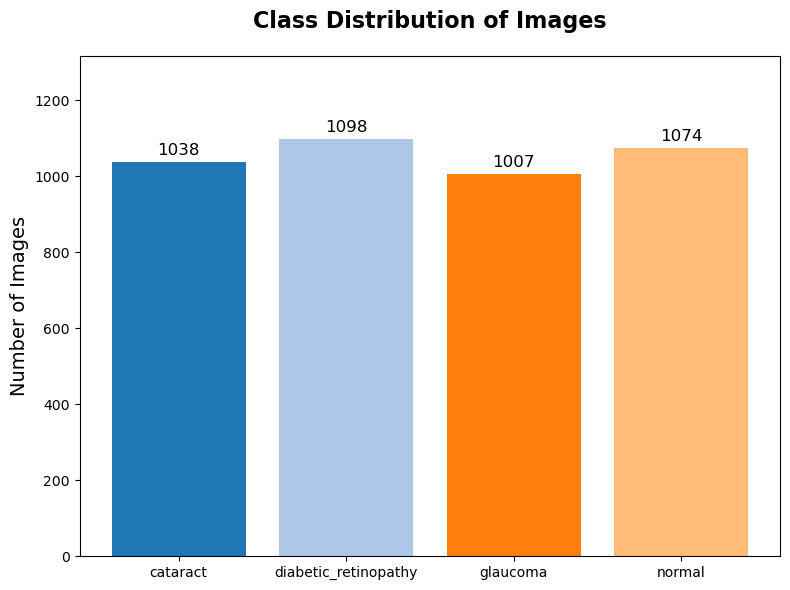

In [14]:
# Generate a list of colors for each bar (one color per class)
colors = plt.colormaps['tab20'].colors  # Access the 'tab20' colormap
colors = (colors * ((len(class_image_counts) // len(colors)) + 1))[:len(class_image_counts)]

# Create a bar plot for class distribution
plt.figure(figsize=(8, 6))
bars = plt.bar(class_image_counts.keys(), class_image_counts.values(), color=colors)

# Add counts on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 10, str(height), ha='center', va='bottom', fontsize=12)

plt.ylabel('Number of Images', fontsize=14)
plt.title('Class Distribution of Images', fontsize=16, fontweight='bold', pad = 20)

# Adjust y-axis limit to be 12% more than the maximum value
y_max = max(class_image_counts.values())
plt.ylim(0, y_max * 1.2)

# Adjust layout for better spacing
plt.tight_layout()

# Show plot
plt.show()


## 3.3 Image Size Distribution

In [15]:
# Convert image sizes to a DataFrame
image_sizes_df = pd.DataFrame(image_sizes, columns=["Class", "Size"])

# Separate Width and Height for plotting
image_sizes_df[['Width', 'Height']] = pd.DataFrame(image_sizes_df['Size'].tolist(), index=image_sizes_df.index)

In [16]:
image_sizes_df.describe()

,Width,Height
count,4217.000000,4217.000000
mean,532.856533,492.554897
std,462.662272,291.388249
min,256.000000,256.000000
25%,256.000000,256.000000
50%,512.000000,512.000000
75%,512.000000,512.000000
max,2592.000000,1728.000000


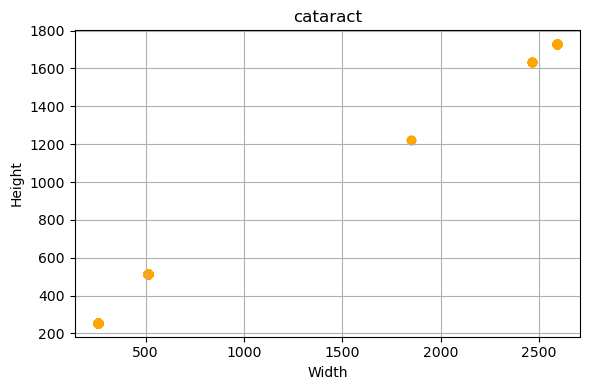

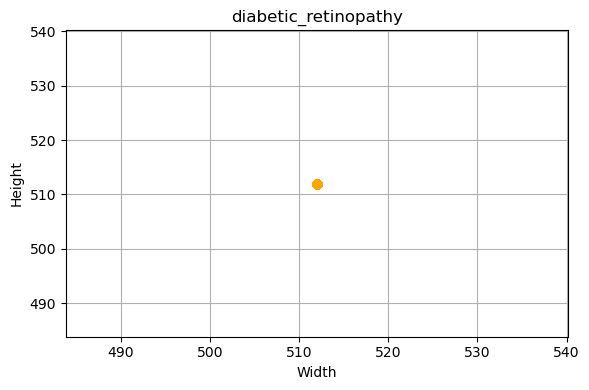

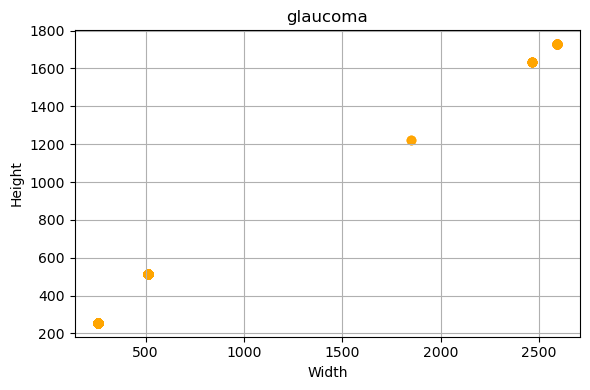

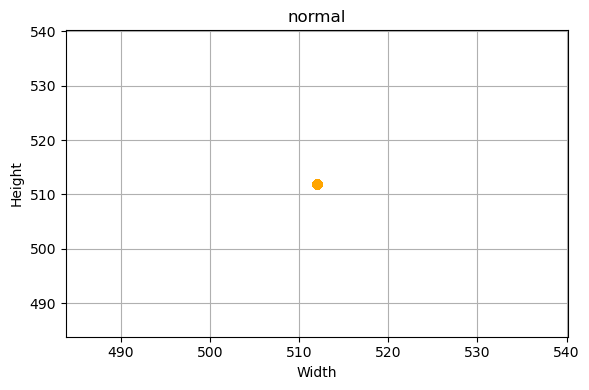

In [17]:
# Scatter Plot for each class: Width vs. Height
for class_name in class_image_counts.keys():
    class_data = image_sizes_df[image_sizes_df['Class'] == class_name]
    
    plt.figure(figsize=(6, 4))
    plt.scatter(class_data['Width'], class_data['Height'], alpha=0.5, color='orange')
    plt.xlabel('Width')
    plt.ylabel('Height')
    plt.title(f"{class_name}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## 3.4 Check Duplicated Images

In [18]:
class_image_files = defaultdict(set)  # To store filenames of images per class
duplicates_found = False  # Flag to track if duplicates are found

for class_name in class_names:
    class_path = os.path.join(dataset_dir, class_name)
    
    if os.path.isdir(class_path):
        for file_name in os.listdir(class_path):
            if is_image(file_name):
                # Check if the file is already listed under this class
                if file_name in class_image_files[class_name]:
                    print(f"Duplicate found in class '{class_name}': {file_name}")
                    duplicates_found = True
                else:
                    class_image_files[class_name].add(file_name)

if not duplicates_found:
    print("No duplicate images found in any class.")

No duplicate images found in any class.


In [19]:
all_image_files = defaultdict(set)  # To store filenames across all classes
duplicates_found_across_classes = False  # Flag to track if duplicates are found across classes

for class_name in class_names:
    class_path = os.path.join(dataset_dir, class_name)
    
    if os.path.isdir(class_path):
        for file_name in os.listdir(class_path):
            if is_image(file_name):
                # Check for duplicates across different classes
                if file_name in all_image_files:
                    print(f"Duplicate found across classes: '{file_name}' in classes '{all_image_files[file_name]}' and '{class_name}'")
                    duplicates_found_across_classes = True
                else:
                    all_image_files[file_name].add(class_name)

if not duplicates_found_across_classes:
    print("No duplicate images found across classes.")

Duplicate found across classes: '1415_right.jpg' in classes '{'cataract'}' and 'glaucoma'
Duplicate found across classes: '625_left.jpg' in classes '{'cataract'}' and 'glaucoma'


## 3.5 Check Corrupted Image Files

In [20]:
# Check for corrupted image files
corrupted_images = []

for class_name in class_names:
    class_path = os.path.join(dataset_dir, class_name)
    
    if os.path.isdir(class_path):
        for file_name in os.listdir(class_path):
            if is_image(file_name):
                file_path = os.path.join(class_path, file_name)
                try:
                    # Try to open the image to check for corruption
                    img = Image.open(file_path)
                    img.verify()  # Verify if the image is corrupted
                except (IOError, SyntaxError) as e:
                    # If an error occurs, the image is corrupted
                    print(f"Corrupted image found: {file_name} in class '{class_name}'")
                    corrupted_images.append(file_path)

In [21]:
# print the list of corrupted images
if corrupted_images:
    print("List of corrupted images:")
    for corrupted_image in corrupted_images:
        print(corrupted_image)
else:
    print("No corrupted images found.")

No corrupted images found.


## 3.6 Check Image Quality

In [22]:
%%time
# Initialize counters for each issue type
blurry_count = 0
exposure_count = 0
distortion_count = 0
noise_count = 0

# Thresholds
MAX_ISSUES = 5

CPU times: total: 0 ns
Wall time: 0 ns


In [23]:
# Step 1: Detect blurry images using Laplacian variance
def is_blurry(image_path, threshold=5):
    global blurry_count
    if blurry_count >= MAX_ISSUES:
        return False  # Stop checking once we reach the limit
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    laplacian_var = cv2.Laplacian(img, cv2.CV_64F).var()
    if laplacian_var < threshold:
        blurry_count += 1
        return True
    return False

In [24]:
# Step 2: Check for overexposed or underexposed images
def is_exposed(image_path, overexposure_threshold=254, underexposure_threshold=1):
    global exposure_count
    if exposure_count >= MAX_ISSUES:
        return False  # Stop checking once we reach the limit
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Check percentage of pixels that are overexposed or underexposed
    overexposed = np.sum(gray > overexposure_threshold) / gray.size
    underexposed = np.sum(gray < underexposure_threshold) / gray.size
    if overexposed > 0.1 or underexposed > 0.1:
        exposure_count += 1
        return True
    return False

In [25]:
# Step 3: Check for distortions or misalignment (detect edges)
def has_distortion(image_path):
    global distortion_count
    if distortion_count >= MAX_ISSUES:
        return False  # Stop checking once we reach the limit
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150)
    # If edge detection shows too few edges, it might be distorted
    edge_ratio = np.sum(edges) / (edges.shape[0] * edges.shape[1])
    if edge_ratio < 0.05:
        distortion_count += 1
        return True
    return False

In [26]:
# Step 4: Detect noise by comparing with a smoothed version
def has_noise(image_path, threshold=50):
    global noise_count
    if noise_count >= MAX_ISSUES:
        return False  # Stop checking once we reach the limit
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    smoothed = cv2.GaussianBlur(gray, (5, 5), 0)
    # Calculate the difference between the original and smoothed image
    diff = cv2.absdiff(gray, smoothed)
    noise = np.sum(diff) / (diff.shape[0] * diff.shape[1])
    if noise > threshold:
        noise_count += 1
        return True
    return False

In [27]:
# Function to check all conditions for a given image
def check_image_quality(image_path):
    if is_blurry(image_path):
        print(f"Blurry image found: {image_path}")
    
    if is_exposed(image_path):
        print(f"Overexposed or Underexposed image found: {image_path}")
    
    if has_distortion(image_path):
        print(f"Distorted or Misaligned image found: {image_path}")
    
    if has_noise(image_path):
        print(f"High Noise image found: {image_path}")

In [28]:
class_names

['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']

In [29]:
%%time

for class_name in class_names:
    class_path = os.path.join(dataset_dir, class_name)
    print(f'===== In progress in class: {class_name} ...')

    if os.path.isdir(class_path):
        for file_name in os.listdir(class_path):
            if is_image(file_name):
                file_path = os.path.join(class_path, file_name)
                check_image_quality(file_path)

===== In progress in class: cataract ...
Overexposed or Underexposed image found: dataset\cataract\0_left.jpg
Overexposed or Underexposed image found: dataset\cataract\103_left.jpg
Overexposed or Underexposed image found: dataset\cataract\1062_right.jpg
Overexposed or Underexposed image found: dataset\cataract\1083_left.jpg
Overexposed or Underexposed image found: dataset\cataract\1084_right.jpg
===== In progress in class: diabetic_retinopathy ...
Distorted or Misaligned image found: dataset\diabetic_retinopathy\10218_left.jpeg
Distorted or Misaligned image found: dataset\diabetic_retinopathy\10218_right.jpeg
Blurry image found: dataset\diabetic_retinopathy\10464_left.jpeg
Distorted or Misaligned image found: dataset\diabetic_retinopathy\10503_right.jpeg
Distorted or Misaligned image found: dataset\diabetic_retinopathy\10651_left.jpeg
Distorted or Misaligned image found: dataset\diabetic_retinopathy\10651_right.jpeg
Blurry image found: dataset\diabetic_retinopathy\10782_left.jpeg
=====

### Detect blurry images

If we lower the blur threshold toward zero, the filtered image will become blurrier.

Even with a very low threshold of 5 in the Laplacian method for detecting blurry images, the images in the dataset remain recognizable and are not excessively blurry.

### Check for overexposed or underexposed images

- Overexposed Threshold: 240 to 255 (indicating very bright or near-white pixels)
- Underexposed Threshold: 0 to 20 (indicating very dark or near-black pixels)

Even in the filtered result, where the overexposure threshold is greater than 254 and the underexposure threshold is less than 1, the image remains recognizable and acceptable.

### Check for distortions or misalignment (detect edges)

The condition (edge_ratio < 0.05) is used to assess whether the image contains enough defined edges to be considered "normal" or if it may exhibit distortions or misalignments. A lower threshold typically indicates that the image could be more distorted or misaligned.

To perform edge detection, the cv2.Canny(gray, 50, 150) function is used, where lower values enhance the sensitivity of the edge detection process.

Even with this threshold in place, the filtered image remains acceptable and recognizable, as it still meets the criteria for usability despite potential edge distortions.

### Detect noise

In the has_noise(image_path, threshold=50) function, the threshold value determines the amount of difference required between the original image and the smoothed (blurred) image for it to be considered "noisy."

A higher threshold requires a larger difference between the original and blurred images to flag the image as noisy. This means that only images with very noticeable noise will be identified.

With this threshold, no images were flagged as noisy, indicating that the image quality is already acceptable and free from destructive noise.

# 4. Exploratory Data Analysis (EDA)

From the image preprocessing steps above, here are the **conclusions** or **handling** for each step.

### Tabel

In [30]:
df.sample(20)

,filename,label,path
2261,1307_right.jpg,glaucoma,dataset\glaucoma\1307_right.jpg
1652,10947_left.jpeg,diabetic_retinopathy,dataset\diabetic_retinopathy\10947_left.jpeg
1288,10368_left.jpeg,diabetic_retinopathy,dataset\diabetic_retinopathy\10368_left.jpeg
4168,3420_right.jpg,normal,dataset\normal\3420_right.jpg
509,_166_7102152.jpg,cataract,dataset\cataract\_166_7102152.jpg
426,_116_4683353.jpg,cataract,dataset\cataract\_116_4683353.jpg
1002,_79_1123955.jpg,cataract,dataset\cataract\_79_1123955.jpg
1851,11270_right.jpeg,diabetic_retinopathy,dataset\diabetic_retinopathy\11270_right.jpeg
1345,10464_right.jpeg,diabetic_retinopathy,dataset\diabetic_retinopathy\10464_right.jpeg
1344,10464_left.jpeg,diabetic_retinopathy,dataset\diabetic_retinopathy\10464_left.jpeg


### Dataset structure

We have four classes of eye disease classifications:
- cataract
- diabetic retinopathy
- glaucoma
- normal

We have left, right, and unnamed eye fundus images.

Total Images: 4217

Image Format Counts:
- .jpg: 2918
- .png: 201
- .jpeg: 1098

Class distribution:
- cataract: 1038
- diabetic_retinopathy: 1098
- glaucoma: 1007
- normal: 1074

### Corrupted Image Files

No corrupted images found.

### Duplicated Images

No duplicate images were found within their respective classes.

- Duplicate found across classes: '1415_right.jpg' in classes '{'cataract'}' and 'glaucoma'
- Duplicate found across classes: '625_left.jpg' in classes '{'cataract'}' and 'glaucoma'

I will delete these duplicate images later for machine learning purposes.

### Image Format Distribution

Image Format Counts:
- .jpg: 2918
- .png: 201
- .jpeg: 1098

To avoid inconsistencies and ensure smooth processing in deep learning models, it’s best to convert all images to a single format (preferably .jpg because it is the most common in our dataset).

Standardizing the image format ensures consistency in data preprocessing, improves computational efficiency, and minimizes compatibility issues across different deep learning frameworks. Mixed formats (.jpg, .png, .jpeg) can lead to variations in color channels (e.g., PNG supports transparency), compression artifacts, and file size differences, potentially affecting model performance.

Converting all images to a single format, preferably .jpg, optimizes storage, speeds up training, and ensures uniform handling of pixel data. This standardization reduces preprocessing complexity, eliminates unnecessary transformations, and enhances reproducibility, ultimately leading to more reliable and accurate eye disease classification.

In [31]:
# Define input and output directories
dataset_dir = "dataset"
output_dir = "new_dataset"

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# Supported image formats (excluding .jpg since we don’t need to convert it)
valid_extensions = ('.jpeg', '.png', '.bmp', '.gif', '.tiff', '.webp')

In [32]:
%%time

# Loop through each subdirectory (category)
for subfolder in os.listdir(dataset_dir):
    subfolder_path = os.path.join(dataset_dir, subfolder)

    if os.path.isdir(subfolder_path):  # Ensure it's a folder
        output_subfolder = os.path.join(output_dir, subfolder)  # Maintain structure
        os.makedirs(output_subfolder, exist_ok=True)  # Create subfolder in output

        # Process images in the subfolder
        for filename in os.listdir(subfolder_path):
            file_path = os.path.join(subfolder_path, filename)

            # Skip .jpg files, only convert other formats
            if filename.lower().endswith(valid_extensions):
                try:
                    # Open and convert to RGB mode
                    img = Image.open(file_path).convert("RGB")
                    new_filename = os.path.splitext(filename)[0] + ".jpg"
                    img.save(os.path.join(output_subfolder, new_filename), "JPEG", quality=95)
                    # print(f"Converted: {subfolder}/{filename} → {new_filename}")
                except Exception as e:
                    print(f"Error processing {subfolder}/{filename}: {e}")  # Log errors
            elif filename.lower().endswith(".jpg"):  # If it's already a .jpg, just copy it
                src_path = os.path.join(subfolder_path, filename)
                dest_path = os.path.join(output_subfolder, filename)
                if not os.path.exists(dest_path):  # Avoid redundant copies
                    os.system(f'cp "{src_path}" "{dest_path}"')  # Use system copy command
                    # print(f"Copied: {subfolder}/{filename} (already .jpg)")

print("Conversion completed successfully.")

Conversion completed successfully.
CPU times: total: 1min 49s
Wall time: 4min 1s


### Image Size Distribution

As observed in the image size distribution class scatter plot, images in each class have varying sizes, and the sizes differ across classes. This needs to be addressed because deep learning models (e.g., CNNs) typically require fixed input sizes (such as 224×224, 256×256, or 299×299, depending on the architecture). Resizing ensures uniformity and prevents shape mismatches during training.

Best Image Sizes for CNNs:
- 224×224 → Recommended for ResNet, MobileNet, EfficientNet (fast, low computation)
- 256×256 → Slightly larger, useful for detailed features
- 299×299 → Required for InceptionV3 (if using this model)

Resizing without preserving aspect ratio may distort images. Instead, we can resize while keeping aspect ratio and padding.

I will resize the images later during preprocessing because we don't yet know which model will best suit our dataset. We should perform trial and error to determine the best performance. However, it is worth trying my resize_with_padding function below.

In [33]:
# Define input and output directories
dataset_dir = "test_image_resize"
output_dir = "result_test_image_resize"

# Target image size (change based on model)
target_size = (224, 224)  # Example: ResNet/MobileNet/Inception

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

In [34]:
def resize_with_padding(img, target_size=(224, 224), padding_color=(0, 0, 0)):
    """
    Resizes an image while maintaining aspect ratio and adds padding if necessary.
    :param img: PIL Image object
    :param target_size: Tuple (width, height)
    :param padding_color: Background color for padding (default: black)
    :return: Resized and padded image
    """
    old_size = img.size  # (width, height)
    
    # Compute new size while maintaining aspect ratio
    ratio = min(target_size[0] / old_size[0], target_size[1] / old_size[1])
    new_size = (int(old_size[0] * ratio), int(old_size[1] * ratio))
    img = img.resize(new_size, Image.BILINEAR)

    # Create a new blank image and paste the resized image at the center
    new_img = Image.new("RGB", target_size, padding_color)
    paste_position = ((target_size[0] - new_size[0]) // 2, (target_size[1] - new_size[1]) // 2)
    new_img.paste(img, paste_position)

    return new_img

In [35]:
%%time

# Process each class folder inside the dataset
for class_folder in os.listdir(dataset_dir):
    class_folder_path = os.path.join(dataset_dir, class_folder)

    if os.path.isdir(class_folder_path):  # Ensure it's a folder
        output_class_folder = os.path.join(output_dir, class_folder)  # Maintain structure
        os.makedirs(output_class_folder, exist_ok=True)  # Create class subfolder in output

        # Process only .jpg images in the class folder
        for filename in os.listdir(class_folder_path):
            if filename.lower().endswith(".jpg"):  # Process only .jpg images
                file_path = os.path.join(class_folder_path, filename)
                output_path = os.path.join(output_class_folder, filename)

                # Skip if the image already exists in the output folder
                if os.path.exists(output_path):
                    print(f"Skipping (already exists): {class_folder}/{filename}")
                    continue
                
                try:
                    img = Image.open(file_path).convert("RGB")  # Convert to RGB mode
                    img = resize_with_padding(img, target_size)  # Resize with aspect ratio maintained
                    
                    # Save the resized image in the same format
                    img.save(output_path, "JPEG", quality=100)
                    # print(f"Resized: {class_folder}/{filename} to {target_size}")
                except Exception as e:
                    print(f"Error processing {class_folder}/{filename}: {e}")  # Log errors

print("Resizing completed successfully.")

Resized: 1/_6_6261868.jpg to (224, 224)
Resized: 2/Glaucoma_002.jpg to (224, 224)
Resizing completed successfully.
CPU times: total: 156 ms
Wall time: 201 ms


### Image Quality

#### Blurry images

Lowering the blur threshold makes the image appear blurrier because more details are smoothed out.

Even with a very low threshold of 5, the images in the dataset remain clear and recognizable. This means the images are not overly affected by the blur, ensuring they still convey the necessary visual information.

#### Overexposed or underexposed images

An overexposed threshold represents very bright areas, close to pure white, while an underexposed threshold represents very dark areas, close to pure black.

Even when applying stricter thresholds, where overexposure is above 254 and underexposure is below 1, the images remain clear and acceptable. This ensures the adjustments do not compromise the overall visibility and usability of the images.

#### Distorted or misaligned images

The condition (edge_ratio < 0.05) checks if the image has enough clearly defined edges to be considered "normal" or if it might show distortions or misalignments. A lower threshold suggests the image may be more distorted or misaligned.

Edge detection is performed using a method that highlights edges with high sensitivity, ensuring even subtle edges are captured.

Even with this threshold applied, the image remains clear and usable, meeting the necessary criteria for recognition despite potential edge-related distortions.

#### Noise in images

The `has_noise` function checks for noise in an image by comparing the original image to a smoothed (blurred) version. The threshold value, set to 50, refers to the minimum level of difference required between the original and the smoothed image for the image to be classified as "noisy."

With this threshold of 50, only images with very noticeable noise would be flagged. In this case, no images were identified as noisy, confirming that the image quality is high and free from significant noise.